In [1]:
import numpy as np
import pandas as pd
import os
import pymongo

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

# pip install matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
%matplotlib inline
import seaborn as sns
train_on_gpu = torch.cuda.is_available()
from sklearn.decomposition import PCA
from sklearn import preprocessing
if not train_on_gpu:
    print('CUDA is not available.')
else:
    print('CUDA is available.')

CUDA is not available.


In [2]:
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
sns.set_style('whitegrid')
from os import listdir
from os.path import isfile, join
from pandas_datareader import data
import yfinance as yf
import math
import pmdarima as pm

In [132]:
AAPL_df = pd.read_csv('collected_df.csv', index_col = [0])

AAPL_cols = AAPL_df.columns.tolist()
AAPL_cols.remove('Close')
AAPL_cols = ['Close'] + AAPL_cols
AAPL_df = AAPL_df[AAPL_cols]
# AAPL_df = AAPL_df[['Date', 'Close']]
AAPL_df

,Close,Date,^DJI_Close,^IXIC_Close,^GSPC_Close,^RLG_Close,^NYA_Close,DX-Y.NYB_Close,EURUSD=X_Close,GBPUSD=X_Close,...,GACDFSA066MSFRBPHI,GACDISA066MSFRBNY,BACTSAMFRBDAL,IR,IQ,PPIACO,CPIAUCSL,CPILFESL,MICH,CSCICP03USM665S
0,27.332500,2015-01-02,17832.990234,4726.810059,2058.199951,960.280029,10830.919922,91.080002,1.208941,1.557972,...,13.3,12.5,-4.5,126.0,126.1,192.000,234.747,239.811,2.5,101.143074
1,26.562500,2015-01-05,17501.650391,4652.569824,2020.579956,943.780029,10607.679688,91.379997,1.194643,1.528491,...,13.3,12.5,-4.5,126.0,126.1,192.000,234.747,239.811,2.5,101.143074
2,26.565001,2015-01-06,17371.640625,4592.740234,2002.609985,935.020020,10514.870117,91.500000,1.193902,1.525832,...,13.3,12.5,-4.5,126.0,126.1,192.000,234.747,239.811,2.5,101.143074
3,26.937500,2015-01-07,17584.519531,4650.470215,2025.900024,946.880005,10627.129883,91.889999,1.187536,1.513798,...,13.3,12.5,-4.5,126.0,126.1,192.000,234.747,239.811,2.5,101.143074
4,27.972500,2015-01-08,17907.869141,4736.189941,2062.139893,964.159973,10800.540039,92.370003,1.183600,1.510757,...,13.3,12.5,-4.5,126.0,126.1,192.000,234.747,239.811,2.5,101.143074
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2002,131.860001,2022-12-23,33203.929688,10497.860352,3844.820068,2165.620117,15188.450195,104.309998,1.060333,1.203992,...,-13.7,-11.2,-20.0,141.8,150.7,258.012,298.990,301.460,4.4,96.919411
2003,130.029999,2022-12-27,33241.558594,10353.230469,3829.250000,2144.899902,15218.259766,104.180000,1.064022,1.208415,...,-13.7,-11.2,-20.0,141.8,150.7,258.012,298.990,301.460,4.4,96.919411
2004,126.040001,2022-12-28,32875.710938,10213.290039,3783.219971,2117.199951,15037.320312,104.459999,1.063717,1.202733,...,-13.7,-11.2,-20.0,141.8,150.7,258.012,298.990,301.460,4.4,96.919411
2005,129.610001,2022-12-29,33220.800781,10478.089844,3849.280029,2163.790039,15241.209961,103.839996,1.062925,1.202848,...,-13.7,-11.2,-20.0,141.8,150.7,258.012,298.990,301.460,4.4,96.919411


In [133]:


# Select columns that are not of the date type
num_columns = AAPL_df.select_dtypes(include=['number']).columns

# Calculate the IQR for each value column
Q1 = AAPL_df[num_columns].quantile(0.25)
Q3 = AAPL_df[num_columns].quantile(0.75)
IQR = Q3 - Q1

# Calculate the IQR for each value column
outliers_mask = (AAPL_df[num_columns] < (Q1 - 1.5 * IQR)) | (AAPL_df[num_columns] > (Q3 + 1.5 * IQR))

# Calculate the average of each column
column_means = AAPL_df[num_columns].mean()

# Replace outliers with averages
# df_no_outliers = AAPL_df.copy()
AAPL_df[num_columns] = AAPL_df[num_columns].where(~outliers_mask, column_means, axis=1)


# Load the "cooked_text_score.csv" file
cooked_text_score_df = pd.read_csv("cooked_text_score.csv")

# Add the "my_score" column to the df_no_outliers DataFrame using the "Date" column
df_no_outliers = AAPL_df.merge(cooked_text_score_df[['Date', 'my_score']], on='Date', how='left')

# Fill in the missing values in the "my_score" column with 0.5
df_no_outliers['my_score'].fillna(0.5, inplace=True)
AAPL_df = df_no_outliers

In [128]:
# missing_values_count = df_no_outliers['my_score'].isna().sum()
# missing_values_count
AAPL_df.to_csv("all_features.csv")

In [90]:
# Calculate the n-day rolling average for each column

# Assume that the data has been loaded into a DataFrame object called df_no_outliers and that outliers have been processed
# Select columns that are not of the date type
avg_num_columns = AAPL_df.select_dtypes(include=['number']).columns

window_size = 10
df_rolling_mean = AAPL_df[avg_num_columns].rolling(window=window_size).mean()

df_rolling_mean['Date'] = AAPL_df['Date']

# Delete rows containing null values
df_rolling_mean.dropna(inplace=True)
AAPL_df = df_rolling_mean
df_rolling_mean

,Close,^DJI_Close,^IXIC_Close,^GSPC_Close,^RLG_Close,^NYA_Close,DX-Y.NYB_Close,EURUSD=X_Close,GBPUSD=X_Close,GC=F_Close,...,BACTSAMFRBDAL,IR,IQ,PPIACO,CPIAUCSL,CPILFESL,MICH,CSCICP03USM665S,my_score,Date
9,27.239500,17593.835938,4659.919971,2026.946997,948.075000,10643.626953,91.896001,1.187487,1.499801,1221.030005,...,-4.5,126.000000,126.100000,192.000000,234.747000,239.811000,2.500000,101.143074,0.456349,2015-01-15
10,27.156000,17561.693945,4650.676953,2023.069006,946.654999,10626.566992,92.040000,1.182967,1.518225,1230.120007,...,-4.5,126.000000,126.100000,192.000000,234.747000,239.811000,2.500000,101.143074,0.456349,2015-01-16
11,27.217750,17563.051953,4650.904980,2023.266016,947.240997,10631.661035,92.207001,1.179482,1.516276,1239.150000,...,-4.5,126.000000,126.100000,192.000000,234.747000,239.811000,2.500000,101.143074,0.456312,2015-01-20
12,27.300000,17581.315820,4658.372949,2026.217017,949.125995,10652.214062,92.347001,1.175561,1.515167,1246.589990,...,-4.5,126.000000,126.100000,192.000000,234.747000,239.811000,2.500000,101.143074,0.434358,2015-01-21
13,27.416250,17604.261914,4668.365918,2029.942004,951.283997,10675.436035,92.582001,1.172961,1.515236,1255.599988,...,-4.5,126.000000,126.100000,192.000000,234.747000,239.811000,2.500000,101.143074,0.477980,2015-01-22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2002,136.839000,33341.788672,10786.387109,3893.857007,2214.950000,15215.482129,96.018868,1.060475,1.220954,1797.150000,...,-20.0,127.488391,129.878974,207.256199,256.473957,262.809901,3.139263,96.919411,0.553466,2022-12-23
2003,135.392999,33265.440625,10707.336133,3877.726001,2200.966992,15190.441113,95.950217,1.061655,1.219404,1800.580005,...,-20.0,127.488391,129.878974,207.256199,256.473957,262.809901,3.139263,96.919411,0.529022,2022-12-27
2004,133.449999,33142.147656,10602.984180,3854.083008,2182.221997,15137.919141,95.950217,1.062610,1.216968,1799.980005,...,-20.0,127.488391,129.878974,207.256199,256.473957,262.809901,3.139263,96.919411,0.488766,2022-12-28
2005,132.089999,33067.592578,10533.704199,3839.479004,2169.638989,15112.542090,95.950217,1.062636,1.213687,1801.180005,...,-20.0,127.488391,129.878974,207.256199,256.473957,262.809901,3.139263,96.919411,0.547615,2022-12-29


In [134]:
from sklearn.preprocessing import MinMaxScaler


def data_normalisation(df):
    scaler=MinMaxScaler(feature_range=(0,1))
    
    for column_name in list(df.columns.values):
        if column_name == 'Date':
            continue
        the_list = df[column_name].tolist()
        the_list = np.array(the_list)
        the_list = scaler.fit_transform(the_list.reshape(-1,1))
        df.drop(column_name, axis = 1, inplace = True)
        df[column_name] = the_list
    return df
        
def split_train_test_data(df, lookback,num_feature=1):
    df_list = df.loc[:, df.columns != 'Date'].values.tolist()
    res_list = df['Close'].tolist()
    res_list = np.array(res_list)
    print(len(res_list))
    data = []
    res_data = []

    for index in range(len(df_list) - lookback -1): 
        the_list = df_list[index: index + lookback]
        the_list= np.array(the_list)
#         the_list = the_list.reshape(-1)
        the_list= np.transpose(the_list)
        if index==0:
            print(the_list)
        data.append(the_list)
        res_data.append(res_list[index + lookback:index + lookback + 1])

    data = np.array(data)
    res_data = np.array(res_data)
    
    test_set_size = int(np.round(0.2*data.shape[0]))
    train_set_size = data.shape[0] - (test_set_size)*2
    
    x_train = data[:train_set_size]
    y_train = res_data[:train_set_size]
    y_train = np.squeeze(y_train)
    
    x_val = data[train_set_size:train_set_size+test_set_size]
    y_val = res_data[train_set_size:train_set_size+test_set_size]
    y_val = np.squeeze(y_val)
    
    x_test = data[train_set_size+test_set_size:]
    y_test = res_data[train_set_size+test_set_size:]
    y_test = np.squeeze(y_test)
    
    return [x_train, y_train,x_val,y_val, x_test, y_test]

In [131]:
normalised_AAPL_df
normalised_AAPL_df.to_csv("okk_data.csv")

Close                 1.000000
^DJI_Close            0.915418
^IXIC_Close           0.956904
^GSPC_Close           0.964615
^RLG_Close            0.967636
^NYA_Close            0.898405
DX-Y.NYB_Close        0.173919
EURUSD=X_Close       -0.034668
GBPUSD=X_Close       -0.312329
GC=F_Close            0.911964
SI=F_Close            0.798004
CL=F_Close            0.642447
WM1NS                 0.962097
WM2NS                 0.979241
ICSA                  0.096479
CCSA                  0.148999
JTSJOL                0.879026
PAYEMS                0.314822
RSXFS                 0.953775
TCU                   0.178608
UMCSENT              -0.841918
BUSINV                0.806873
INDPRO                0.113886
GACDFSA066MSFRBPHI    0.114458
GACDISA066MSFRBNY     0.103769
BACTSAMFRBDAL         0.055576
IR                    0.808778
IQ                    0.824742
PPIACO                0.848911
CPIAUCSL              0.918500
CPILFESL              0.924508
MICH                  0.850614
CSCICP03

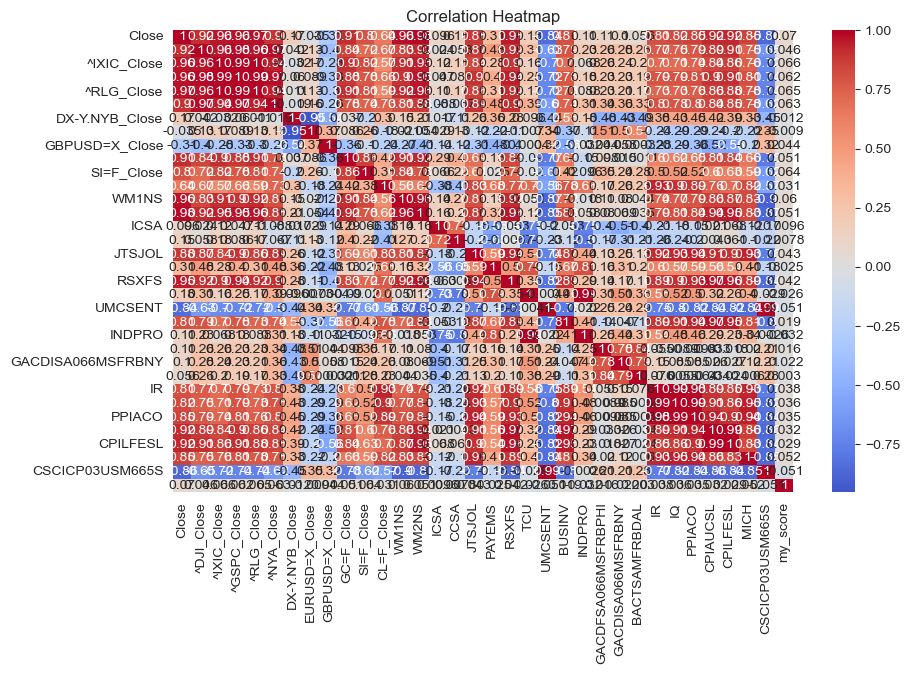

In [148]:

# Select columns of numeric type
num_columns = normalised_AAPL_df.select_dtypes(include=['number']).columns

# Calculate the correlation between columns of values 
correlation_matrix = normalised_AAPL_df[num_columns].corr()

# Relevance of selecting the "Close" column
close_correlation = correlation_matrix['Close']

# Output the relevance of the "Close" column
print(close_correlation)

# Heat map using seaborn
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap')
plt.show()

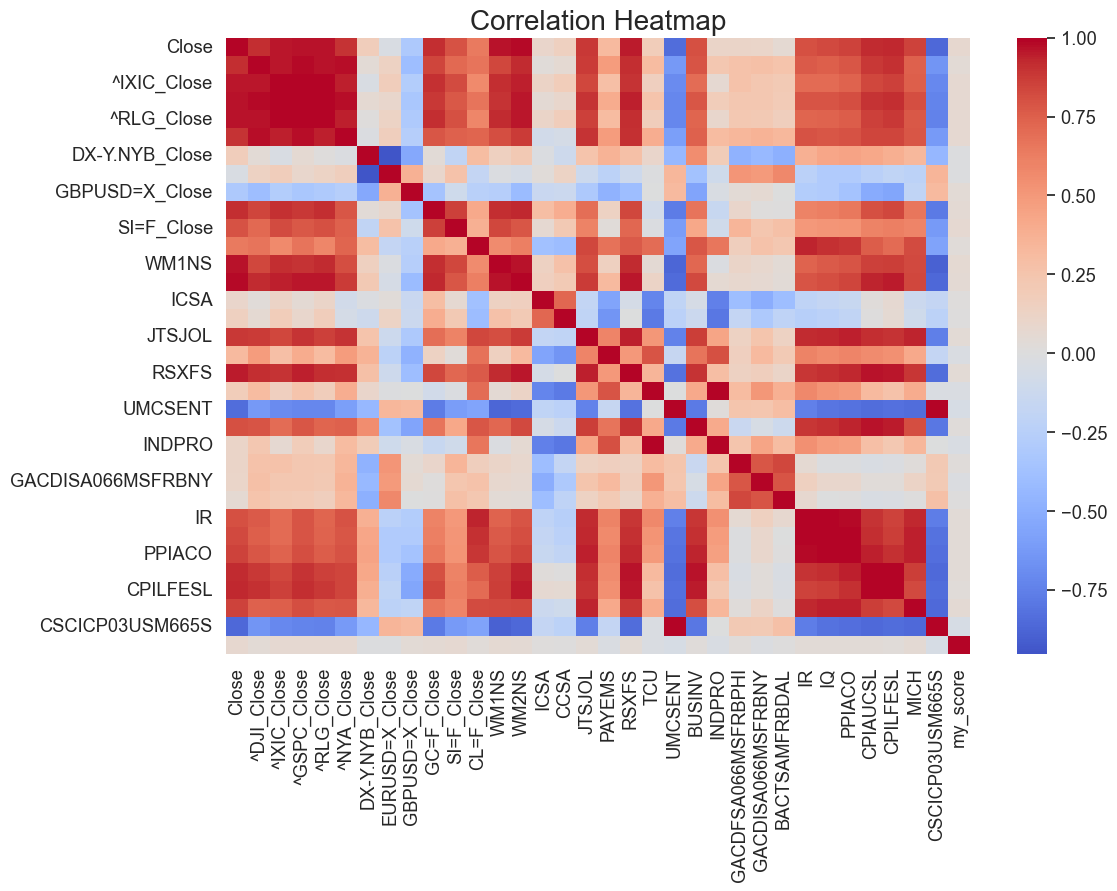

In [150]:
# Set image size, font size and heat map spacing
fig, ax = plt.subplots(figsize=(12, 8))
sns.set(font_scale=1.2)

# Plotting heat maps
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', center=0, ax=ax)

# Set title
ax.set_title('Correlation Heatmap', fontsize=20)

# Save image to file
plt.savefig('correlation_heatmap.png', dpi=300, bbox_inches='tight')

# Display images
plt.show()

In [136]:
lookback = 15 # choose sequence length
normalised_AAPL_df = data_normalisation(AAPL_df)
x_train, y_train,x_val,y_val, x_test, y_test = split_train_test_data(normalised_AAPL_df, lookback,num_feature=1)# change the num_feature value for using more features
# x_test = np.squeeze(x_test)
print(x_train[0])

2007
[[0.0297789  0.02494904 0.02496473 0.02730125 0.03379333 0.03398151
  0.02965345 0.03117454 0.03051593 0.02584288 0.02454132 0.02882234
  0.03012389 0.03459308 0.0355026 ]
 [0.10278454 0.08711055 0.08096045 0.09103066 0.10632668 0.09826119
  0.09369489 0.09241008 0.08358347 0.07855123 0.08757981 0.08775295
  0.08960015 0.10188528 0.09519728]
 [0.0390116  0.03271504 0.02764069 0.03253697 0.03980714 0.03708293
  0.03374469 0.03347244 0.03159126 0.02578155 0.03117229 0.03290844
  0.03397453 0.04101233 0.04164674]
 [0.07721029 0.06453287 0.05847723 0.06632566 0.07853799 0.07269808
  0.06712094 0.06535851 0.06139555 0.05512761 0.06414199 0.06519676
  0.0684217  0.07887835 0.07506036]
 [0.03296827 0.02556219 0.02163024 0.02695363 0.0347098  0.0313434
  0.02789621 0.02747878 0.02540059 0.02095696 0.02659455 0.02819247
  0.03009111 0.03663989 0.03563443]
 [0.23944136 0.2134117  0.20259017 0.21567958 0.23589908 0.2255066
  0.21726654 0.21519337 0.20848424 0.20255863 0.21954956 0.21935132
 

In [137]:
class MyDataLoader(Dataset):
    def __init__(self, x_list, y_list):

        self.x_list = x_list
        self.y_list = y_list
        
    def __len__(self):
        return len(self.x_list)
    

    def __getitem__(self, idx):
        x_data = self.x_list[idx]
        y_data = self.y_list[idx]
        sample = {'Data': x_data, 'Labels': y_data}

        return sample

In [138]:
class AttentionalLSTM(nn.Module):
    def __init__(self, input_size, qkv, hidden_size, num_layers, output_size, bidirectional=False):
        super(AttentionalLSTM, self).__init__()

        self.input_size = input_size
        self.qkv = qkv
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size

        self.query = nn.Linear(input_size, qkv)
        self.key = nn.Linear(input_size, qkv)
        self.value = nn.Linear(input_size, qkv)

        self.attn = nn.Linear(qkv, input_size)
        self.scale = math.sqrt(qkv)
        self.activation =  nn.Tanh()
        self.out_activation = nn.Tanhshrink()

        self.lstm = nn.LSTM(input_size=input_size,
                            hidden_size=hidden_size,
                            num_layers=num_layers,
                            batch_first=True,
                            bidirectional=bidirectional)
        self.dropout = nn.Dropout(0.1)

        if bidirectional:
            self.fc1 = nn.Linear(hidden_size * 2, output_size)
            # self.fc2 = nn.Linear(hidden_size, output_size)
        else:
            self.fc1 = nn.Linear(hidden_size*self.num_layers, hidden_size)
            self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        batchsize = x.shape[0]
        Q, K, V = self.query(x), self.key(x), self.value(x)

        dot_product = torch.matmul(Q, K.permute(0, 2, 1)) / self.scale
        scores = torch.softmax(dot_product, dim=-1)
        scaled_x = torch.matmul(scores, V) + x
#         scaled_x = torch.unsqueeze(scaled_x, -1)
#         print(x.size(), scaled_x.size())

        out = self.attn(scaled_x) + x
        # print(out.size())
        out, (h_n, c_n) = self.lstm(out)
        out = h_n.permute(1, 0, 2).reshape(batchsize, -1)
        # out = out[:, -1, :]
        out = self.fc1(out)
        out = self.dropout(out)
        # out = self.activation(out)   
        out_rate = self.fc2(out)
        out_rate = self.out_activation(out_rate)
        # print(x.size(), out_rate.size())
        # x = torch.squeeze(x[:,-1,:], 1)
        out_rate = out_rate + x[:,-1,:]
        # print(out_rate.size(), x.size())
        return out_rate
        # return x + out_rate * x

In [139]:
lookback = 15 # choose sequence length
normalised_AAPL_df = data_normalisation(AAPL_df)
x_train, y_train,x_val,y_val, x_test, y_test = split_train_test_data(normalised_AAPL_df, lookback,num_feature=1)# change the num_feature value for using more features
# x_test = np.squeeze(x_test)

2007
[[0.0297789  0.02494904 0.02496473 0.02730125 0.03379333 0.03398151
  0.02965345 0.03117454 0.03051593 0.02584288 0.02454132 0.02882234
  0.03012389 0.03459308 0.0355026 ]
 [0.10278454 0.08711055 0.08096045 0.09103066 0.10632668 0.09826119
  0.09369489 0.09241008 0.08358347 0.07855123 0.08757981 0.08775295
  0.08960015 0.10188528 0.09519728]
 [0.0390116  0.03271504 0.02764069 0.03253697 0.03980714 0.03708293
  0.03374469 0.03347244 0.03159126 0.02578155 0.03117229 0.03290844
  0.03397453 0.04101233 0.04164674]
 [0.07721029 0.06453287 0.05847723 0.06632566 0.07853799 0.07269808
  0.06712094 0.06535851 0.06139555 0.05512761 0.06414199 0.06519676
  0.0684217  0.07887835 0.07506036]
 [0.03296827 0.02556219 0.02163024 0.02695363 0.0347098  0.0313434
  0.02789621 0.02747878 0.02540059 0.02095696 0.02659455 0.02819247
  0.03009111 0.03663989 0.03563443]
 [0.23944136 0.2134117  0.20259017 0.21567958 0.23589908 0.2255066
  0.21726654 0.21519337 0.20848424 0.20255863 0.21954956 0.21935132
 

In [140]:
def train(model, train_loader, val_loader, optimizer, MAE_Loss, NLL_Loss, alpha, gamma):
    n_epochs = 150
    last_epochs=0
    var_value = 0.0
    train_loss_res=[]
    valid_loss_res=[]
    valid_loss_min = np.Inf # track change in validation loss

    for epoch in range(n_epochs):
        train_loss = 0.0
        valid_loss = 0.0
        model.train()
        for i_batch, sample_batched in enumerate(train_loader):
            data_batch,labels_batch = sample_batched['Data'], sample_batched['Labels']
            data=data_batch.float()
            target = labels_batch.float()
#             print(data.size())
            if train_on_gpu:
                data, target = data.cuda(), target.cuda()

            var = torch.tensor([var_value]*data.size(0))
            var = torch.unsqueeze(var, 1)
            if train_on_gpu:
                var = var.cuda()

            optimizer.zero_grad()
            output = model(data)
#             print(output.size(),target.size(), var.size())
            loss = gamma * NLL_Loss(output, target, var) + alpha * MAE_Loss(output, target)
            # criterion(output, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()*data.size(0)


        model.eval()
        for i_batch, sample_batched in enumerate(val_loader):
            data_batch,labels_batch = sample_batched['Data'], sample_batched['Labels']
            data = data_batch.float()
            target = labels_batch.float()
            if train_on_gpu:
                data, target = data.cuda(), target.cuda()

            var = torch.tensor([var_value]*data.size(0))
            var = torch.unsqueeze(var, 1)
            if train_on_gpu:
                var = var.cuda()
            output = model(data)

            # loss = criterion(output, target)
            loss = gamma * NLL_Loss(output, target, var) + alpha * MAE_Loss(output, target)
            valid_loss += loss.item()*data.size(0)

    #     print(len(train_loader.sampler))
        train_loss = train_loss/len(train_loader.sampler)
        valid_loss = valid_loss/len(val_loader.sampler)

        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, train_loss, valid_loss))
        train_loss_res.append(train_loss)
        valid_loss_res.append(valid_loss)

        if valid_loss <= valid_loss_min:
            last_epochs=epoch
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model.state_dict(), 'model_cifar.pt')
            valid_loss_min = valid_loss
        if epoch-last_epochs>50:
            break
    return model

In [141]:
def combine_values(the_list,last=True):
    res=[]
    for i in range(len(the_list)):
        if last:
            if i==len(the_list)-1:
                for ii in range(len(the_list[i])):
                    res.append(the_list[i][ii])
            else:
                res.append(the_list[i][0])
        else:
            res.append(the_list[i][0])
    res=np.array(res)
    return res

In [142]:
def forecast_accuracy(forecast, actual):
    print(forecast.shape)
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
#     corr = np.corrcoef(forecast, actual)[0,1]   # corr
#     mins = np.amin(np.hstack([forecast[:,None], 
#                               actual[:,None]]), axis=1)
#     maxs = np.amax(np.hstack([forecast[:,None], 
#                               actual[:,None]]), axis=1)
#     minmax = 1 - np.mean(mins/maxs)             # minmax
#     acf1 = acf(fc-test)[1]                      # ACF1
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse})
#             'acf1':acf1, 
#             ,'corr':corr, 'minmax':minmax

In [143]:
def evaluate(model, x_train, y_train, x_val, y_val, x_test, y_test, the_df, is_stock =  True):
    actual_values = np.concatenate((y_train.detach().cpu().numpy(),  y_val.detach().cpu().numpy()), axis=0)
    actual_values = np.concatenate((actual_values,y_test.detach().cpu().numpy()), axis=0)
    print(actual_values.shape)
    actual = actual_values
#     combine_values(actual_values)
    print(actual.shape)
    devide = 16
    train_len = len(x_train)//devide
    

    # actual =  np.concatenate(actual)
    if train_on_gpu:
        for i in range(devide):
            if i == devide -1:
                temp_predict = model(x_train[int(i*train_len):].cuda()).detach().cpu().numpy()
            else:
                temp_predict = model(x_train[int(i*train_len):int((i+1)*train_len)].cuda()).detach().cpu().numpy()
            if i ==0:
                predict = temp_predict[:]
            else:     
                predict = np.concatenate((predict, temp_predict), axis=None)
        for i in range(devide):
            if i == devide -1:
                temp_predict = model(x_val[int(i*train_len):].cuda()).detach().cpu().numpy()
            else:
                temp_predict = model(x_val[int(i*train_len):int((i+1)*train_len)].cuda()).detach().cpu().numpy()
            if i ==0:
                val_predict = temp_predict[:]
            else:     
                val_predict = np.concatenate((val_predict, temp_predict), axis=None)
        for i in range(devide):
            if i == devide -1:
                temp_predict = model(x_test[int(i*train_len):].cuda()).detach().cpu().numpy()
            else:
                temp_predict = model(x_test[int(i*train_len):int((i+1)*train_len)].cuda()).detach().cpu().numpy()
            if i ==0:
                test_predict = temp_predict[:]
            else:     
                test_predict = np.concatenate((test_predict, temp_predict), axis=None)
                
#         val_predict = model(x_val.cuda()).detach().cpu().numpy()
#         test_predict = model(x_test.cuda()).detach().cpu().numpy()
    else:
        predict = model(x_train).detach().numpy()
        val_predict = model(x_val).detach().numpy()
        test_predict = model(x_test).detach().numpy()
    print('predict',predict.shape)   
    train_num = len(predict)
    train_sum = 0 
    for i in range(train_num):
        train_sum += np.abs(actual_values[i]-predict[i])
    print('Train Loss:',train_sum.sum()/train_num)

    val_num = len(val_predict)
    val_sum = 0 
    for i in range(val_num):
        val_sum += np.abs(actual_values[train_num+i]-val_predict[i])
    print('Val Loss:',val_sum.sum()/val_num)

    test_num = len(test_predict)
    test_sum = 0 
    for i in range(test_num):
        test_sum += np.abs(actual_values[val_num+train_num+i]-test_predict[i])
    print('Test Loss:',test_sum.sum()/test_num)
#     predict=combine_values(predict,True)
    print('predict',predict.shape)
#     val_predict=combine_values(val_predict,True)
    print('val_predict',val_predict.shape)
    
#     val_predict = np.append(val_predict,test_predict[0])
#     print(len(val_predict))
    os.environ["KMP_DUPLICATE_LIB_OK"]  =  "TRUE"
    
    print('test_predict',test_predict.shape)
    the_df['Date'] = pd.to_datetime(the_df['Date'], format='%Y-%m-%d')

    data_date = the_df['Date'].tolist()
    data_date = np.array(data_date[16:])
        # data_len = len(data_date)
    fig = figure(figsize=(25, 5), dpi=300)
    fig.patch.set_facecolor((1.0, 1.0, 1.0))
    plt.plot(data_date, actual, label="Actual Prices", color='b')
    plt.plot(data_date[:len(predict)], predict, label="Predicted Training Prices", color='r')
    plt.plot(data_date[len(predict):len(predict)+len(val_predict)], val_predict, label="Predicted Validation Prices", color='g')
    plt.plot(data_date[len(predict)+len(val_predict):], test_predict, label="Predicted Testing Prices", color='k')
    plt.title("Predicted Close Prices and Actual Close Prices")

    plt.grid(b=None, which='major', axis='y', linestyle='--')
    plt.legend()
    plt.savefig('Data_Pred.png')
    plt.show()

    
    torch.cuda.empty_cache()
    print(len(actual_values[:train_num]),len(actual_values[train_num:val_num+train_num]),len(actual_values[val_num+train_num:]))
    print(len(predict),len(val_predict),len(test_predict))
    print(len(x_val))

    print(forecast_accuracy(actual_values[:train_num],predict))
    print(forecast_accuracy(actual_values[train_num:val_num+train_num],val_predict))
    print(forecast_accuracy(actual_values[val_num+train_num:],test_predict))


In [144]:
torch.cuda.empty_cache()

In [145]:
evaluate(model, x_train, y_train, x_val, y_val, x_test, y_test, normalised_AAPL_df)

AttributeError: 'numpy.ndarray' object has no attribute 'detach'

In [146]:
class AttentionalLSTM(nn.Module):
    def __init__(self, input_size, qkv, hidden_size, num_layers, output_size, bidirectional=False):
        super(AttentionalLSTM, self).__init__()

        self.input_size = input_size
        self.qkv = qkv
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size

        self.query = nn.Linear(input_size, qkv)
        self.key = nn.Linear(input_size, qkv)
        self.value = nn.Linear(input_size, qkv)

        self.attn = nn.Linear(qkv, input_size)
        self.scale = math.sqrt(qkv)
        self.activation =  nn.Tanh()
        self.out_activation = nn.Tanhshrink()

        self.lstm = nn.LSTM(input_size=input_size,
                            hidden_size=hidden_size,
                            num_layers=num_layers,
                            batch_first=True,
                            bidirectional=bidirectional)
        self.dropout = nn.Dropout(0.1)

        if bidirectional:
            self.fc1 = nn.Linear(hidden_size * 2, output_size)
            # self.fc2 = nn.Linear(hidden_size, output_size)
        else:
            self.fc1 = nn.Linear(hidden_size*self.num_layers, hidden_size)
            self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        batchsize = x.shape[0]
        Q, K, V = self.query(x), self.key(x), self.value(x)

        dot_product = torch.matmul(Q, K.permute(0, 2, 1)) / self.scale
        scores = torch.softmax(dot_product, dim=-1)
        scaled_x = torch.matmul(scores, V) + x
#         scaled_x = torch.unsqueeze(scaled_x, -1)
#         print(x.size(), scaled_x.size())

        out = self.attn(scaled_x) + x
#         print(out.size())
        out, (h_n, c_n) = self.lstm(out)
#         out = h_n.permute(1, 0, 2).reshape(batchsize, -1)
        out = out[:, -1, :]
        out = self.fc1(out)
        out = self.dropout(out)
        # out = self.activation(out)   
        out_rate = self.fc2(out)
        out_rate = self.out_activation(out_rate)
        print(x.size(), out_rate.size())
        x = torch.unsqueeze(x[:,0,-1], 1)
        out_rate = out_rate + x
#         print(x.size(), out_rate.size())
#         print(out_rate.size(), x[:,-1,0].size())
        return out_rate
        # return x + out_rate * x

2007
[[0.0297789  0.02494904 0.02496473 0.02730125 0.03379333 0.03398151
  0.02965345 0.03117454 0.03051593 0.02584288 0.02454132 0.02882234
  0.03012389 0.03459308 0.0355026 ]
 [0.10278454 0.08711055 0.08096045 0.09103066 0.10632668 0.09826119
  0.09369489 0.09241008 0.08358347 0.07855123 0.08757981 0.08775295
  0.08960015 0.10188528 0.09519728]
 [0.0390116  0.03271504 0.02764069 0.03253697 0.03980714 0.03708293
  0.03374469 0.03347244 0.03159126 0.02578155 0.03117229 0.03290844
  0.03397453 0.04101233 0.04164674]
 [0.07721029 0.06453287 0.05847723 0.06632566 0.07853799 0.07269808
  0.06712094 0.06535851 0.06139555 0.05512761 0.06414199 0.06519676
  0.0684217  0.07887835 0.07506036]
 [0.03296827 0.02556219 0.02163024 0.02695363 0.0347098  0.0313434
  0.02789621 0.02747878 0.02540059 0.02095696 0.02659455 0.02819247
  0.03009111 0.03663989 0.03563443]
 [0.23944136 0.2134117  0.20259017 0.21567958 0.23589908 0.2255066
  0.21726654 0.21519337 0.20848424 0.20255863 0.21954956 0.21935132
 

D:\anaconda\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size

D:\anaconda\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning: Using a target size (torch.Size([11])) that is different to the input size (torch.Size([11, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([14, 34, 15]) torch.Size([14, 1])
Epoch: 0 	Training Loss: 1.094145 	Validation Loss: 20.231102
Validation loss decreased (inf --> 20.231102).  Saving model ...
torch.Size([32, 34, 15]) torch.Size([32, 1])


D:\anaconda\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning: Using a target size (torch.Size([14])) that is different to the input size (torch.Size([14, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size

torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([11, 34, 15]) torch.Size([11, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size

torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size

torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([11, 34, 15]) torch.Size([11, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size

torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size

torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([11, 34, 15]) torch.Size([11, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size

torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size

torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([11, 34, 15]) torch.Size([11, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size

torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size

torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([11, 34, 15]) torch.Size([11, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size

torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size

torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([11, 34, 15]) torch.Size([11, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size

torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size

torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([11, 34, 15]) torch.Size([11, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size

torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size

torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([11, 34, 15]) torch.Size([11, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size

torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size

torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([11, 34, 15]) torch.Size([11, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size

torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size

torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([11, 34, 15]) torch.Size([11, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size

torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size

torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([11, 34, 15]) torch.Size([11, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size

torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size

torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([11, 34, 15]) torch.Size([11, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size

torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size

torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([11, 34, 15]) torch.Size([11, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size

torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size([32, 34, 15]) torch.Size([32, 1])
torch.Size

C:\Users\15128\AppData\Local\Temp\ipykernel_30728\879466313.py:89: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=None, which='major', axis='y', linestyle='--')


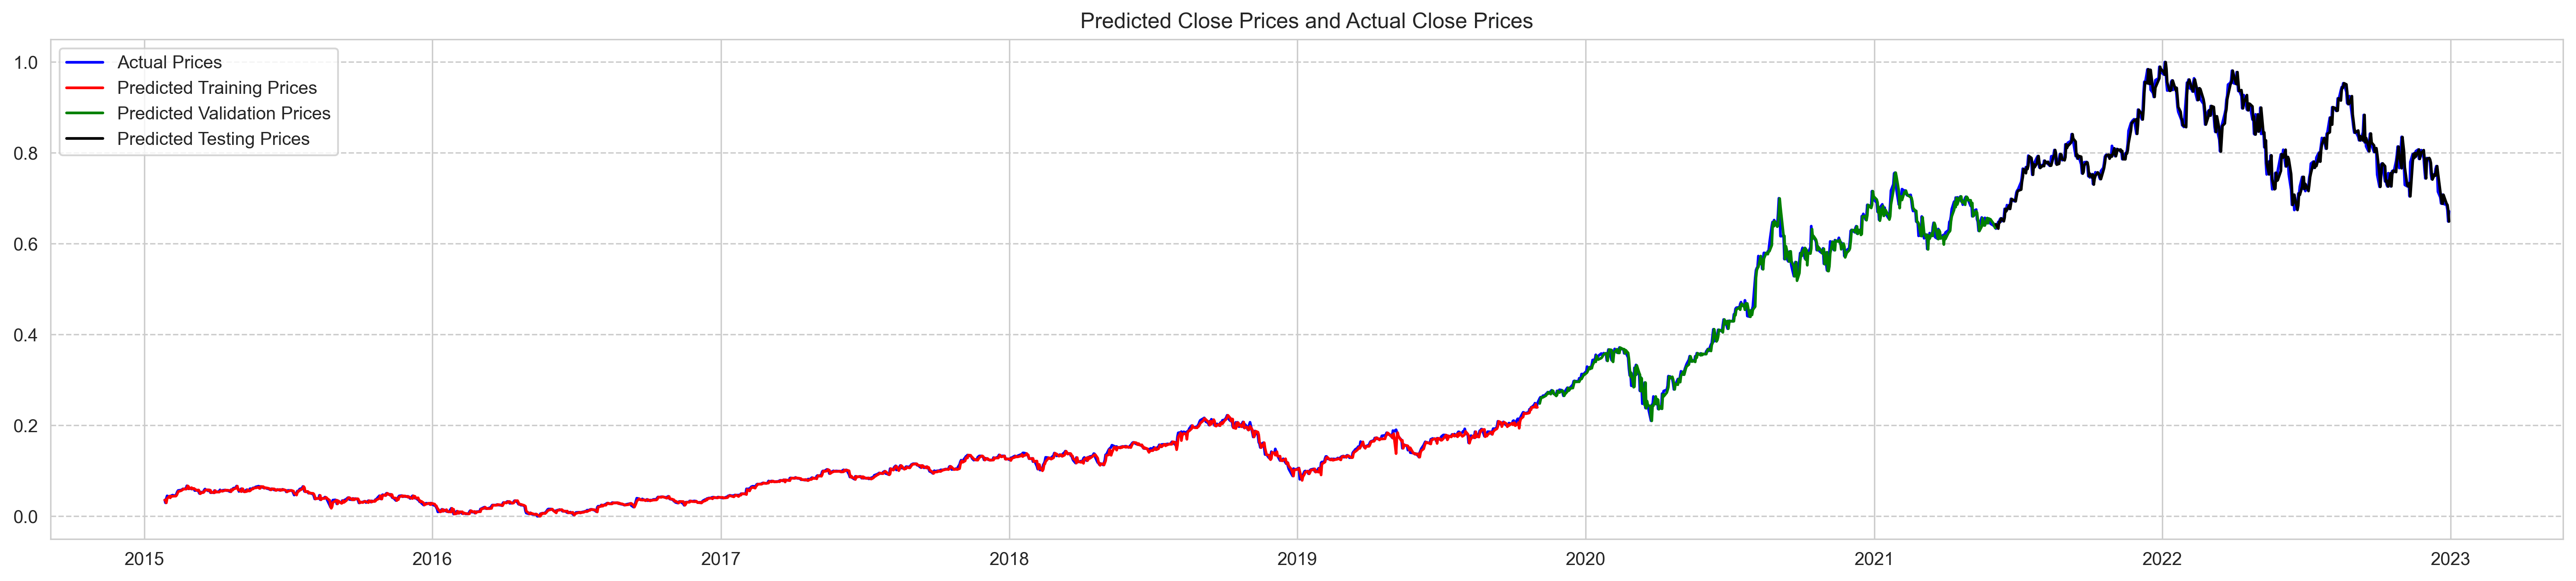

1195 398 398
1195 398 398
398
(1195,)
{'mape': 3.0016565, 'me': 0.0010168619, 'mae': 0.0700028, 'mpe': 0.66213965, 'rmse': 0.086624028587296}
(398,)
{'mape': 0.43275443, 'me': 0.0022806271, 'mae': 0.18092982, 'mpe': 0.13813977, 'rmse': 0.2256331951629066}
(398,)
{'mape': 0.11492158, 'me': 0.00029016705, 'mae': 0.093409374, 'mpe': 0.010514389, 'rmse': 0.11636736303484618}


In [147]:
lookback = 15 # choose sequence length
normalised_AAPL_df = data_normalisation(AAPL_df)
x_train, y_train,x_val,y_val, x_test, y_test = split_train_test_data(normalised_AAPL_df, lookback,num_feature=1)# change the num_feature value for using more features
# x_test = np.squeeze(x_test)
print(x_train[0])

# print('x_train.shape = ', x_train.shape)
# print('y_train.shape = ', y_train.shape)
# print('x_test.shape = ', x_test.shape)
# print('y_test.shape = ', y_test.shape)
# print('x_val.shape = ', x_val.shape)
# print('y_val.shape = ', y_val.shape)
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
x_val = torch.from_numpy(x_val).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)
y_val = torch.from_numpy(y_val).type(torch.Tensor)

dataset_train = MyDataLoader(x_train, y_train)
dataset_test = MyDataLoader(x_test, y_test)
dataset_val = MyDataLoader(x_val, y_val)

batch_size = 32
train_loader = DataLoader(dataset=dataset_train, batch_size=batch_size, num_workers=0, pin_memory=True)
val_loader = DataLoader(dataset=dataset_val, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader = DataLoader(dataset=dataset_test, batch_size=batch_size, shuffle=True, num_workers=0)

input_dim = len(x_train[0][0])
hidden_dim = 128
num_layers = 1
output_dim = 1
print(input_dim)
model = AttentionalLSTM(input_dim, input_dim, hidden_dim, num_layers, output_dim)

if train_on_gpu:
    model.cuda()
MAE_Loss = nn.L1Loss()
# criterion = torch.nn.MSELoss()
NLL_Loss = nn.GaussianNLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
alpha = 100
gamma = 0.0001

model = train(model, train_loader, val_loader, optimizer, MAE_Loss, NLL_Loss, alpha, gamma)
#     model.load_state_dict(torch.load('1_googd_model_without.pt'))

evaluate(model, x_train, y_train, x_val, y_val, x_test, y_test, normalised_AAPL_df)

array([[[0.0297789 , 0.02494904, 0.02496473, ..., 0.03012389,
         0.03459308, 0.0355026 ],
        [0.10278454, 0.08711055, 0.08096045, ..., 0.08960015,
         0.10188528, 0.09519728],
        [0.0390116 , 0.03271504, 0.02764069, ..., 0.03397453,
         0.04101233, 0.04164674],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.30769231, 0.30769231, 0.30769231, ..., 0.30769231,
         0.30769231, 0.30769231],
        [0.91089716, 0.91089716, 0.91089716, ..., 0.91089716,
         0.91089716, 0.91089716]],

       [[0.02494904, 0.02496473, 0.02730125, ..., 0.03459308,
         0.0355026 , 0.03569077],
        [0.08711055, 0.08096045, 0.09103066, ..., 0.10188528,
         0.09519728, 0.09548582],
        [0.03271504, 0.02764069, 0.03253697, ..., 0.04101233,
         0.04164674, 0.04282394],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.3

In [78]:
def evaluate_test(model, x_train, y_train, x_val, y_val, x_test, y_test, the_df, is_stock =  True):
    actual_values = np.concatenate((y_train.detach().cpu().numpy(),  y_val.detach().cpu().numpy()), axis=0)
    actual_values = np.concatenate((actual_values,y_test.detach().cpu().numpy()), axis=0)
    print(actual_values.shape)
    actual = actual_values
#     combine_values(actual_values)
    print(actual.shape)
    devide = 16
    train_len = len(x_train)//devide
    

    # actual =  np.concatenate(actual)
    if train_on_gpu:
        for i in range(devide):
            if i == devide -1:
                temp_predict = model(x_train[int(i*train_len):].cuda()).detach().cpu().numpy()
            else:
                temp_predict = model(x_train[int(i*train_len):int((i+1)*train_len)].cuda()).detach().cpu().numpy()
            if i ==0:
                predict = temp_predict[:]
            else:     
                predict = np.concatenate((predict, temp_predict), axis=None)
        for i in range(devide):
            if i == devide -1:
                temp_predict = model(x_val[int(i*train_len):].cuda()).detach().cpu().numpy()
            else:
                temp_predict = model(x_val[int(i*train_len):int((i+1)*train_len)].cuda()).detach().cpu().numpy()
            if i ==0:
                val_predict = temp_predict[:]
            else:     
                val_predict = np.concatenate((val_predict, temp_predict), axis=None)
        for i in range(devide):
            if i == devide -1:
                temp_predict = model(x_test[int(i*train_len):].cuda()).detach().cpu().numpy()
            else:
                temp_predict = model(x_test[int(i*train_len):int((i+1)*train_len)].cuda()).detach().cpu().numpy()
            if i ==0:
                test_predict = temp_predict[:]
            else:     
                test_predict = np.concatenate((test_predict, temp_predict), axis=None)
                
#         val_predict = model(x_val.cuda()).detach().cpu().numpy()
#         test_predict = model(x_test.cuda()).detach().cpu().numpy()
    else:
        predict = model(x_train).detach().numpy()
        val_predict = model(x_val).detach().numpy()
        test_predict = model(x_test).detach().numpy()
    print('predict',predict.shape)   
    train_num = len(predict)
    train_sum = 0 
    for i in range(train_num):
        train_sum += np.abs(actual_values[i]-predict[i])
    print('Train Loss:',train_sum.sum()/train_num)

    val_num = len(val_predict)
    val_sum = 0 
    for i in range(val_num):
        val_sum += np.abs(actual_values[train_num+i]-val_predict[i])
    print('Val Loss:',val_sum.sum()/val_num)

    test_num = len(test_predict)
    test_sum = 0 
    for i in range(test_num):
        test_sum += np.abs(actual_values[val_num+train_num+i]-test_predict[i])
    print('Test Loss:',test_sum.sum()/test_num)
#     predict=combine_values(predict,True)
    print('predict',predict.shape)
#     val_predict=combine_values(val_predict,True)
    print('val_predict',val_predict.shape)
    
#     val_predict = np.append(val_predict,test_predict[0])
#     print(len(val_predict))
    os.environ["KMP_DUPLICATE_LIB_OK"]  =  "TRUE"
    
    print('test_predict',test_predict.shape)
    the_df['Date'] = pd.to_datetime(the_df['Date'], format='%Y-%m-%d')

    data_date = the_df['Date'].tolist()
    data_date = np.array(data_date[16:])
        # data_len = len(data_date)
    fig = figure(figsize=(25, 5), dpi=300)
    fig.patch.set_facecolor((1.0, 1.0, 1.0))
    plt.plot(data_date[len(predict)+len(val_predict):], actual[len(predict)+len(val_predict):], label="Actual Prices", color='b')
#     plt.plot(data_date[:len(predict)], predict, label="Predicted Training Prices", color='r')
#     plt.plot(data_date[len(predict):len(predict)+len(val_predict)], val_predict, label="Predicted Validation Prices", color='g')
    plt.plot(data_date[len(predict)+len(val_predict):], test_predict, label="Predicted Testing Prices", color='k')
    plt.title("Predicted Close Prices and Actual Close Prices")

    plt.grid(b=None, which='major', axis='y', linestyle='--')
    plt.legend()
    plt.savefig('Data_Pred.png')
    plt.show()

    
    torch.cuda.empty_cache()
    print(len(actual_values[:train_num]),len(actual_values[train_num:val_num+train_num]),len(actual_values[val_num+train_num:]))
    print(len(predict),len(val_predict),len(test_predict))
    print(len(x_val))

    print(forecast_accuracy(actual_values[:train_num],predict))
    print(forecast_accuracy(actual_values[train_num:val_num+train_num],val_predict))
    print(forecast_accuracy(actual_values[val_num+train_num:],test_predict))


(1982,)
(1982,)
torch.Size([1190, 34, 15]) torch.Size([1190, 1])
torch.Size([396, 34, 15]) torch.Size([396, 1])
torch.Size([396, 34, 15]) torch.Size([396, 1])
predict (1190, 1)
Train Loss: 0.0009556314524482278
Val Loss: 0.003486474957128968
Test Loss: 0.004763822061846955
predict (1190, 1)
val_predict (396, 1)
test_predict (396, 1)


C:\Users\15128\AppData\Local\Temp\ipykernel_30728\3746141840.py:89: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=None, which='major', axis='y', linestyle='--')


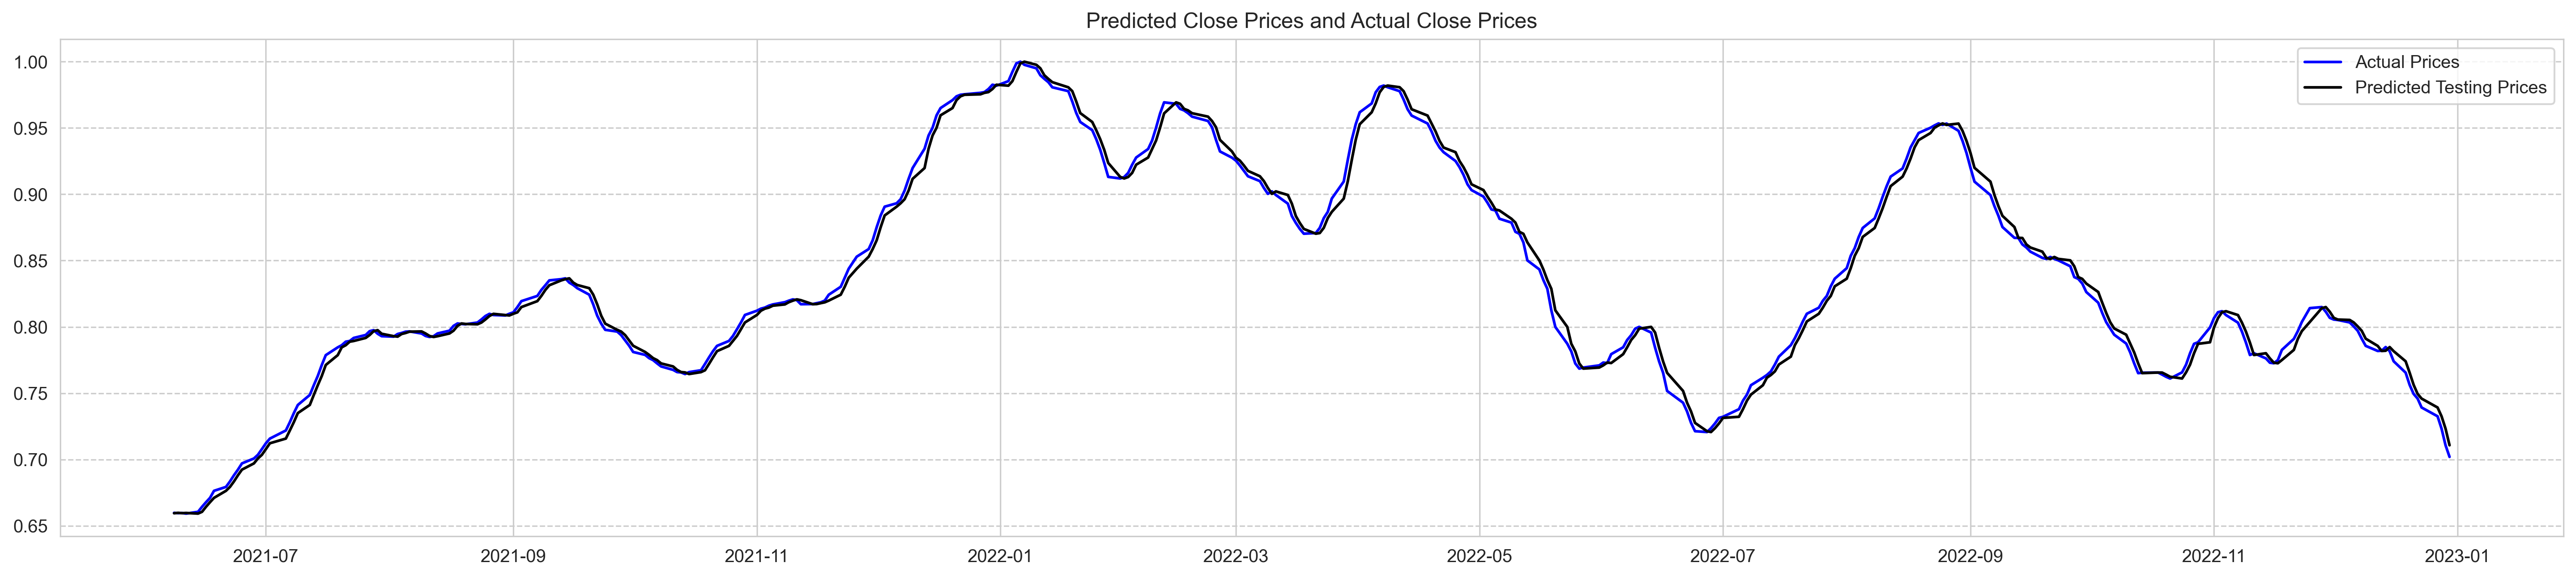

1190 396 396
1190 396 396
396
(1190,)
{'mape': 84999.58, 'me': 0.00018193088, 'mae': 0.07203102, 'mpe': 84999.1, 'rmse': 0.08912142866190009}
(396,)
{'mape': 0.4330543, 'me': 0.0010252198, 'mae': 0.1848388, 'mpe': 0.13615975, 'rmse': 0.23096311210385637}
(396,)
{'mape': 0.11020774, 'me': 0.0001087, 'mae': 0.091762945, 'mpe': 0.009579015, 'rmse': 0.11475771581352379}


In [105]:
evaluate_test(model, x_train, y_train, x_val, y_val, x_test, y_test, normalised_AAPL_df)